<a href="https://colab.research.google.com/github/NunezKant/COVID19_MEX_MASTER/blob/master/Bayesian_MCMC_fitter_State_Agnostic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#!pip install pymc3==3.8
#!pip install seaborn

%matplotlib inline
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano

plt.style.use('seaborn-darkgrid')

Definimos la ecuación diferencial SEIR - utilzamos un modelo simplificado para fittear y obtener la Ro

In [12]:
def SEIR(y, t, p):
    """
    y[0] = S
    y[1] = E
    y[2] = I
    y[3] = R

    
    p[0] = Alpha
    p[1] = Beta
    p[2] = Gamma


    St = S[-1] - (beta*S[-1]*I[-1])*dt
    Et = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
    It = I[-1] + rho*(alpha*E[-1] - gamma*I[-1])*dt
    Rt = gamma*I[-1]
    """

    ds = -p[1]*y[0]*y[2]
    de = p[1]*y[0]*y[2] - p[0]*y[1]
    di = p[0]*y[1] - p[2]*y[2]
    dr = p[2]*y[2]
    return [ds, de, di, dr]

FUNCIONES DE UTILIDAD

In [13]:
def TimeSeriesLoader(url):

  """
  Este Loader se puede cambiar según la fuente, en ese caso, tambien habría que cambiar un poco la función
  GetObs_and_times(estado,Pop)
  """
  df = pd.read_csv(url)

  df['Reporte'] = pd.to_datetime(df['Reporte'])
  df = (df.drop(["Procedencia", "Llegada","Inicio","Caso","Sexo","Edad","Confirmación"], axis=1)
          .dropna()
          .rename(columns = {"Reporte":"Dia"})
          .sort_values(by = ["Dia"])
          .reset_index(drop = True)
        )
  df["Casos_Acumulados"] = np.nan
  Estados = pd.DataFrame({
    "Estado":[],
    "Dia":[],
    "Casos_Acumulados":[]
  })

  for estado in df.Estado.unique():
      df.loc[(df.Estado == estado),"Casos_Acumulados"] =  np.arange(1,len(df.loc[(df.Estado == estado),"Casos_Acumulados"])+1,1)
      tmp = df.loc[df.Estado == estado].drop_duplicates("Dia", keep = 'last').reset_index(drop = True)
      Estados = pd.concat([Estados,tmp])
  return Estados

In [14]:
def GetObs_and_times(estado,Pop):
    from scipy.interpolate import InterpolatedUnivariateSpline
    """
    Esta funcion genera las condiciones inciales para PyMC3 a partir de las observaciones de 
    Infectados en un estado y dada la población del estado (se debe ingresar el número)
    como los registros de recuperados en mexico son nulos se asumen 0.
    """
    yobs = Estados.loc[Estados.Estado == estado,"Casos_Acumulados"].values
    date = Estados.loc[Estados.Estado == estado,"Dia"].values
    days = Estados.loc[Estados.Estado == estado,"Dia"].dt.day.values

    date_df = Estados.loc[Estados.Estado == estado,"Dia"]
    days_i = date_df.apply(lambda x: (x - date_df[0]).days).values
    times = np.arange(0,max(days_i) + 1,1)

    #print(days_i) 
    #print(times) 

    interp = InterpolatedUnivariateSpline(days_i,yobs,k=2)
    obs_interp = interp(times)

    def SI_Day(obs):
        I = obs / Pop
        S = 1 - (I)
        return [S, I]

    def SEIR_Day(obs,r=0, d=0):
        I = obs / Pop
        E = (obs*4) / Pop # Ojo aca con el 4
        D = d
        R = r / Pop
        S = 1 - (E-I-R)
        return [S, E, I, R]

    yobs_arr = np.array([SEIR_Day(obs) for obs in obs_interp])
    times_interp = np.arange(days[0],days[-1]+1,1)

    ## Crear un arreglo de N x 3 para enviar como estados al sistema
    return obs_interp, times, date, yobs_arr

Condiciones iniciales para la ODE, verificamos salida de ODEINT

In [15]:
np.random.seed(666)

# JALISCO (2020-03-14)
Population = 8000000
I_o = 2 / Population  # Tenemos 32 casos
E_o = (2*4)/ Population # Asumimos 4 expuestos por caso
S_o = (1) - (E_o+I_o) # El resto somos suceptibles
R_o = 0 # NO hay ningun recuperado

dias_evaluacion = 120
dt=1
periodo_evaluacion = np.arange(0,dias_evaluacion+dt,dt)

R_o = 3.5 #Escenario Base
alpha = 0.2
gamma = 0.5
beta = R_o * gamma

y0 = np.array([S_o,E_o,I_o,R_o])

args = ((alpha, beta, gamma,),)
 
y = odeint(SEIR,t=periodo_evaluacion,y0=y0, args=args, rtol=1e-08)

Por lo tanto está bien definido el sistema de ecuaciones.

In [16]:
Estados = TimeSeriesLoader("https://gist.githubusercontent.com/said3427/18f39eab460766a17ea4802607dd5522/raw")
Estados.head()

,Estado,Dia,Casos_Acumulados
0,Ciudad De México,2020-02-27,1.0
1,Ciudad De México,2020-02-29,2.0
2,Ciudad De México,2020-03-07,3.0
3,Ciudad De México,2020-03-11,5.0
4,Ciudad De México,2020-03-13,11.0


In [17]:
y_interpol, obs_times, times, yobs_arr = GetObs_and_times("Jalisco",8000000)

obs_times

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [18]:
seir_model = DifferentialEquation(
    func=SEIR,
    times=obs_times,
    n_states=4,
    n_theta=3,
)

In [19]:
yobs_arr[0]

array([9.9999925e-01, 1.0000000e-06, 2.5000000e-07, 0.0000000e+00])

In [20]:
with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1e-5 , shape=4)
    
    # Periodo infeccioso 2 a 14 dias
    # Esto es gamma de 1 / 14 a 1 / 2, de 0.07 a 0.5
    p_gamma = pm.Bound(pm.Normal, lower=0, upper=1)("gamma",0.28, 0.01 )  
    R0 = pm.Bound(pm.Normal, lower=1, upper=5)('R0', 1.5, 0.1)
    p_beta = pm.Deterministic('beta', gamma*R0)

    seir_curves = seir_model(y0=yobs_arr[0], theta=[alpha, p_beta, p_gamma])
    Y = pm.Normal('Y', mu=seir_curves, sd=sigma, observed=yobs_arr)
    
    prior = pm.sample_prior_predictive()
    
    trace = pm.sample(2000,tune=1000, chains=2, cores=8, nuts_kwargs=dict(target_accept=0.95))
    posterior_predictive = pm.sample_posterior_predictive(trace)

    data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [R0, gamma, sigma]
 29%|██▉       | 1154/4000 [00:53<02:09, 22.03it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7feaf03adb90>,
      dtype=object)

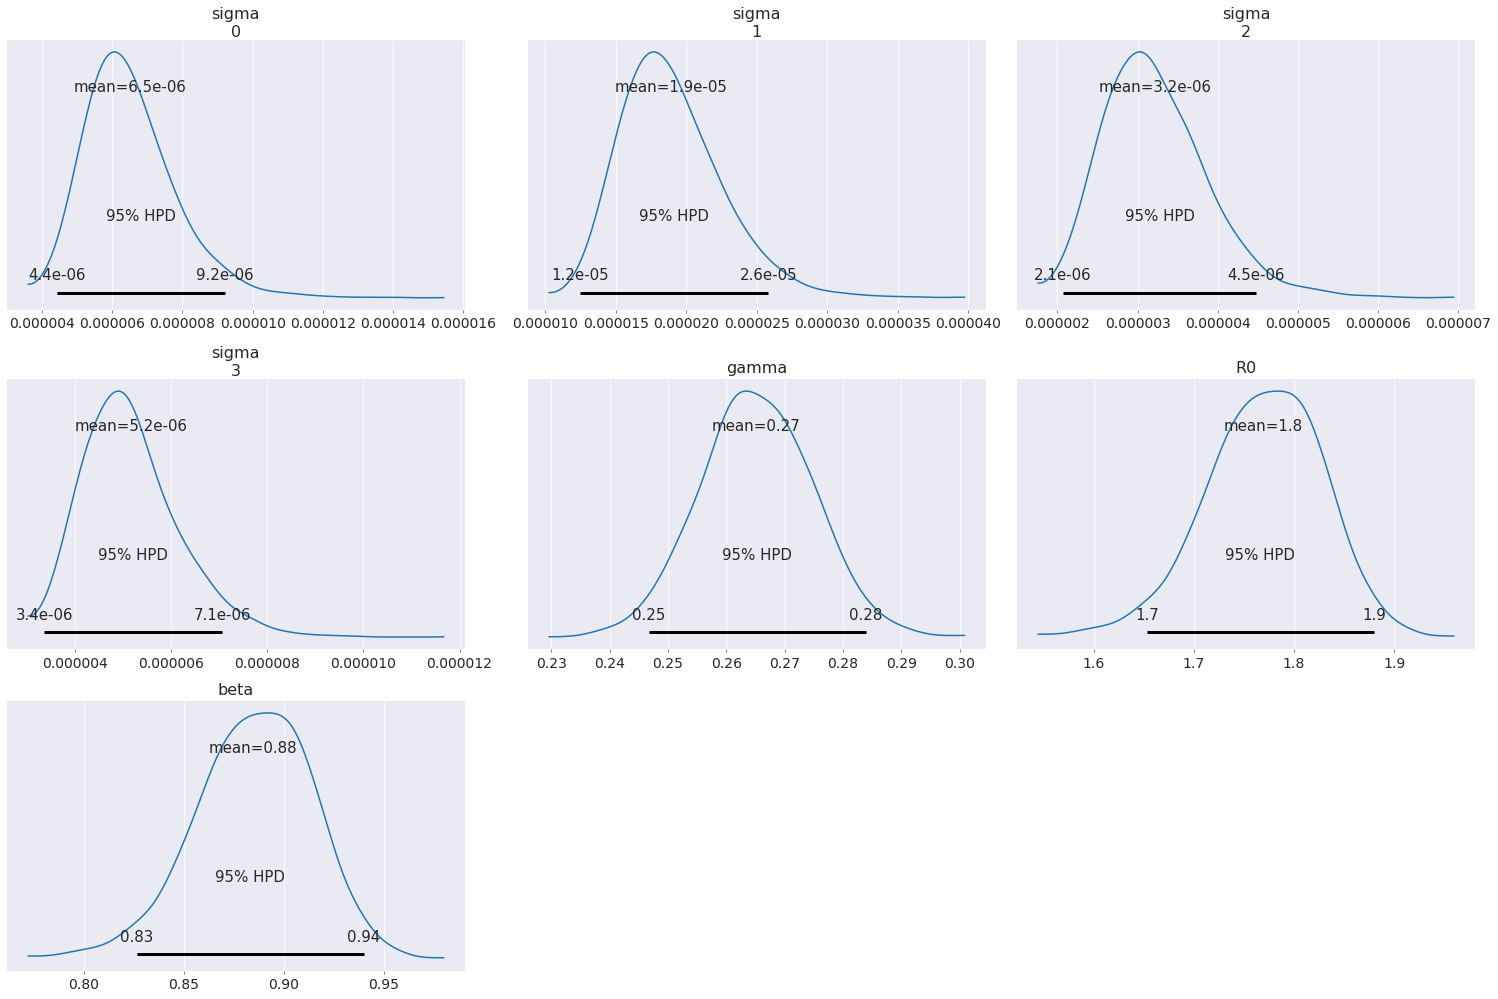

In [21]:
az.plot_posterior(data,round_to=2, credible_interval=0.95)

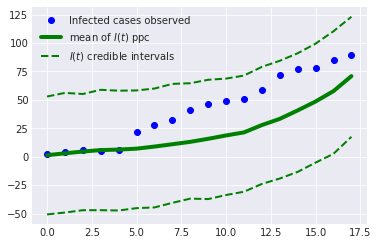

In [23]:
ppc_samples = posterior_predictive["Y"]
mean_ppc = ppc_samples.mean(axis=0)
CriL_ppc = np.percentile(ppc_samples,q=2.5,axis=0)
CriU_ppc = np.percentile(ppc_samples,q=97.5,axis=0)
plt.plot(obs_times,y_interpol,'o', color='b', lw=1, label='Infected cases observed')
plt.plot(obs_times,mean_ppc[:,2]*Population, color='g', lw=4, label=f'mean of $I(t)$ ppc')
plt.plot(obs_times,CriL_ppc[:,2]*Population, '--',  color='g', lw=2, label=f'$I(t)$ credible intervals')
plt.plot(obs_times,CriU_ppc[:,2]*Population, '--',  color='g', lw=2)
plt.legend()

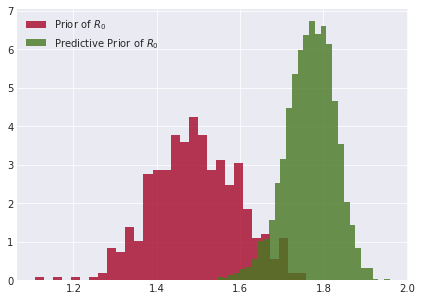

In [24]:
plt.figure(figsize = (7,5))
plt.hist(prior["R0"],histtype="stepfilled",bins=30,alpha = .80, label = f"Prior of $R_0$",color = "#A60628", density = True)
plt.hist(trace["R0"],histtype="stepfilled",bins=30,alpha = .80, label = f"Predictive Prior of $R_0$",color = "#467821", density = True)
plt.legend()

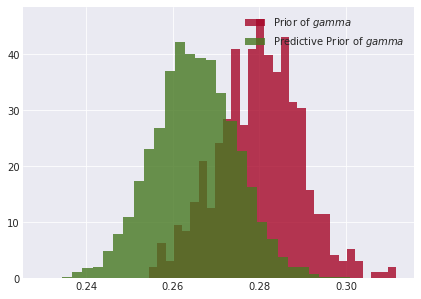

In [26]:
plt.figure(figsize = (7,5))
plt.hist(prior["gamma"],histtype="stepfilled",bins=30,alpha = .80, label = f"Prior of $gamma$",color = "#A60628", density = True)
plt.hist(trace["gamma"],histtype="stepfilled",bins=30,alpha = .80, label = f"Predictive Prior of $gamma$",color = "#467821", density = True)
plt.legend()

In [30]:
#@title Salida de ODEINT { display-mode: "form" }
import plotly.express as px
E_a = y[:,1]*Population
I_a = y[:,2]*Population
Clase = np.array(["Expuestos"]*y[:,1].shape[0] + ["Infectados"]*y[:,1].shape[0])
Dias = np.concatenate([periodo_evaluacion,periodo_evaluacion])
SEIR_df = pd.DataFrame({
    "Casos": np.concatenate([E_a,I_a]),
    "Clase": Clase,
    "Dias" : Dias
})

fig = px.line(SEIR_df, x="Dias", y="Casos", color='Clase',color_discrete_sequence=["green", "red", "goldenrod", "blue"], template = "ggplot2")

fig.update_layout(
    title=f"Predicción de la evolución de COVID-19 en Jalisco, Ro = 1.8",
    xaxis_title="Días",
    yaxis_title="Casos Totales",
    )

#for trace in fig.data:
    #trace.name = trace.name.split('=')[1]

fig.show()

In [27]:
## Guardar modelo
import pickle

with open('S1e-5_Ro1.5,0.1_G0.28.checkpoint,0.1.pkl', 'wb') as buff:
    pickle.dump({'model': model, 'trace': trace}, buff)

In [35]:
#!ls -lha *.pkl
# Cargar modelo
with open('S1e-5_Ro1.5,0.1_G0.28.checkpoint,0.1.pkl', 'rb') as buff:
    data = pickle.load(buff)  

basic_model, trace = data['model'], data['trace']
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma[0],0.000,0.000,0.000,0.000,0.000,0.000,2885.0,2600.0,3354.0,2463.0,1.0
sigma[1],0.000,0.000,0.000,0.000,0.000,0.000,3272.0,3025.0,3615.0,2736.0,1.0
sigma[2],0.000,0.000,0.000,0.000,0.000,0.000,3243.0,3023.0,3536.0,2614.0,1.0
sigma[3],0.000,0.000,0.000,0.000,0.000,0.000,2570.0,2442.0,2713.0,2567.0,1.0
gamma,0.265,0.010,0.247,0.282,0.000,0.000,3534.0,3534.0,3540.0,3121.0,1.0
R0,1.769,0.058,1.665,1.882,0.001,0.001,2160.0,2160.0,2297.0,1773.0,1.0
beta,0.884,0.029,0.832,0.941,0.001,0.000,2160.0,2160.0,2297.0,1773.0,1.0
